---

## **Introduction**

- **Face Recognition:** A facial recognition system is a technology capable of matching a human face from a digital image or a video frame against a database of faces, typically employed to authenticate users through ID verification services, works by pinpointing and measuring facial features from a given image.

- **Convolutional Neural Network/ConvNet/CNN:** convolutional neural networks are a class of deep neural networks used in deep learning and machine learning. Convolutional neural networks are usually used for visual imagery, helping the computer identify and learn from images.

We have used the '**5 Celebrity Faces Dataset**' containing 14-20 photos of each of the celebrities in the training directory and 5 photos of each celebrity in the validation/test directory. (https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset/)



---



## **1. Importing Packages**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder

---
## **2. Face Detection using Haar Cascade Classifier**
Face Detection and preparing the test and train datasets

[[ 50  50 108 108]]


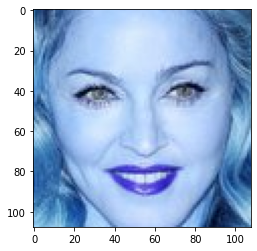

In [ ]:
face_cascade = cv2.CascadeClassifier('drive/MyDrive/Face Recognition - AI Applications/haar.xml')
f = cv2.imread("drive/MyDrive/Face Recognition - AI Applications/data_1/data/train/madonna/httpiamediaimdbcomimagesMMVBMTANDQNTAxNDVeQTJeQWpwZBbWUMDIMjQOTYVUXCRALjpg.jpg")
#f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
faces = face_cascade.detectMultiScale(f,1.3,5)
print(faces)
for x,y,w,h in faces:
    plt.imshow(f[y:y+h, x:x+w])

In [ ]:
#Preparing the train dataset - Total 98 images in train dataset

dirs = "drive/MyDrive/Face Recognition - AI Applications/data_1/data/train/"
img_size = 60

data = []
for name in os.listdir(dirs):
    for f in os.listdir(dirs+name):
        f = cv2.imread(os.path.join(dirs+name, f))
        faces = face_cascade.detectMultiScale(f,1.3,5)
        for x,y,w,h in faces:
            img = f[y:y+h, x:x+w]
            img = cv2.resize(img, (img_size,img_size))
            data.append((img, name))
            
df = pd.DataFrame(data, columns=["image", "name"])
print("Length:",len(df))

Length: 98


In [ ]:
df.head()

,image,name
0,"[[[255, 255, 255], [250, 255, 254], [130, 142,...",jerry_seinfeld
1,"[[[56, 48, 49], [53, 48, 50], [52, 51, 53], [5...",jerry_seinfeld
2,"[[[254, 254, 254], [253, 253, 252], [249, 251,...",jerry_seinfeld
3,"[[[167, 124, 75], [163, 120, 72], [151, 114, 7...",jerry_seinfeld
4,"[[[2, 9, 15], [8, 15, 30], [23, 32, 52], [4, 2...",jerry_seinfeld


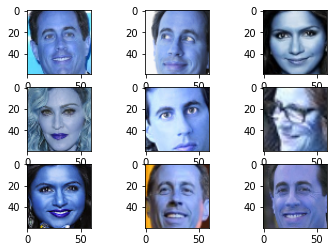

In [ ]:
for i in range(9):
  row = df.iloc[np.random.randint(0, len(df)), :]
  plt.subplot(3,3,i+1)
  plt.imshow(row['image'])

In [ ]:
#Preparing the test dataset - Total 24 images in test dataset

dirs = "drive/MyDrive/Face Recognition - AI Applications/data_1/data/val/"

data = []
for name in os.listdir(dirs):
    for f in os.listdir(dirs+name):
        f = cv2.imread(os.path.join(dirs+name, f))
        faces = face_cascade.detectMultiScale(f,1.3,5)
        for x,y,w,h in faces:
            img = f[y:y+h, x:x+w]
            img = cv2.resize(img, (img_size,img_size))
            data.append((img, name))
            
df_test = pd.DataFrame(data, columns=["image", "name"])
print("Test size: ", len(df_test))

Test size:  24


In [ ]:
df_test.head()

,image,name
0,"[[[126, 129, 128], [115, 117, 117], [95, 93, 9...",ben_afflek
1,"[[[3, 2, 6], [0, 0, 0], [0, 0, 0], [1, 2, 0], ...",ben_afflek
2,"[[[2, 0, 0], [2, 1, 1], [4, 2, 2], [4, 2, 2], ...",ben_afflek
3,"[[[6, 5, 7], [10, 11, 9], [11, 16, 18], [12, 1...",ben_afflek
4,"[[[1, 1, 1], [0, 1, 1], [1, 1, 1], [1, 1, 1], ...",ben_afflek


In [ ]:
#Fitting Label Encoder on the label names

le = LabelEncoder()
le.fit(df["name"].values)

LabelEncoder()

In [ ]:
#Splitting the train dataset into x_train and y_train

x_train = list(df['image'].values)
x_train = np.array(x_train)
x_train = x_train/255
print(x_train.shape)

y_train = le.transform(df["name"].values)
print(y_train.shape)

(98, 60, 60, 3)
(98,)


In [ ]:
#Splitting the test dataset into x_test and y_test

x_test = list(df_test['image'].values)
x_test = np.array(x_test)
x_test = x_test/255
print(x_test.shape)

y_test = le.transform(df_test["name"].values)
print(y_test.shape)

(24, 60, 60, 3)
(24,)


In [ ]:
people_num = len(np.unique(y_train))
people_num

5

---
## **3. Defining Triplet Loss Function and Generating Triplets of A,P,N**
<img src='https://miro.medium.com/max/700/1*EgT2EhqKW5hVrNYX6Y-rKg.png'>

In [ ]:
# d(A,P) + alpha <= d(A,N)

def triplet_loss(y_true, y_pred, alpha = 0.2):
    total_lenght = y_pred.shape.as_list()[-1]
    anchor, positive, negative = y_pred[:,:int(1/3*total_lenght)], y_pred[:,int(1/3*total_lenght):int(2/3*total_lenght)], y_pred[:,int(2/3*total_lenght):]
    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    return loss

In [ ]:
#Generate triplets of A,P,N
#For every A, 100 P and N pairs

def generate_triplets(x, y, num_same, num_diff):
    anchor_images = np.array([]).reshape((-1,)+ x.shape[1:])
    same_images = np.array([]).reshape((-1,)+ x.shape[1:])
    diff_images = np.array([]).reshape((-1,)+ x.shape[1:])
    
    for i in range(len(y)):
        point = y[i]        
        anchor = x[i]
        
        same_pairs = np.where(y == point)[0]
        same_pairs = np.delete(same_pairs , np.where(same_pairs == i))
        diff_pairs = np.where(y != point)[0]
               
        same = x[np.random.choice(same_pairs,num_same)]
        diff = x[np.random.choice(diff_pairs,num_diff)]
        
        anchor_images = np.concatenate((anchor_images, np.tile(anchor, (num_same * num_diff, 1, 1, 1) )), axis = 0)
                                       
        for s in same:
            same_images = np.concatenate((same_images, np.tile(s, (num_same, 1, 1, 1) )), axis = 0)
        diff_images = np.concatenate((diff_images, np.tile(diff, (num_diff, 1, 1, 1) )), axis = 0)
        
    return anchor_images, same_images, diff_images

In [ ]:
# 9800 pairs of A,P,N

anchor_images, same_images, diff_images = generate_triplets(x_train,y_train, num_same= 10, num_diff=10)
print(anchor_images.shape, same_images.shape, diff_images.shape)

(9800, 60, 60, 3) (9800, 60, 60, 3) (9800, 60, 60, 3)


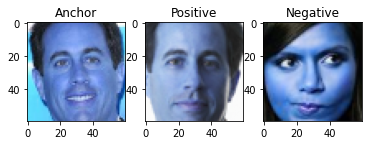

In [ ]:
idx = 200
plt.subplot(1,3,1)
plt.imshow(anchor_images[idx])
plt.title('Anchor')

plt.subplot(1,3,2)
plt.imshow(same_images[idx])
plt.title('Positive')

plt.subplot(1,3,3)
plt.imshow(diff_images[idx])
plt.title('Negative')
print()

---
## **4. Building and Fitting the CNN Model**



In [ ]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(img_size,img_size,3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128))
              
    model.summary()
    return model

In [ ]:
#Giving A,P,N as input to the same model together

anchor_input = tf.keras.layers.Input((img_size, img_size, 3), name='anchor_input')
positive_input = tf.keras.layers.Input((img_size, img_size, 3), name='positive_input')
negative_input = tf.keras.layers.Input((img_size, img_size, 3), name='negative_input')

shared_dnn = get_model()

encoded_anchor = shared_dnn(anchor_input)
encoded_positive = shared_dnn(positive_input)
encoded_negative = shared_dnn(negative_input)


#Merging the 128 length embedding of all 3 (A,P,N) into single vector of size 128*3=384

merged_vector = tf.keras.layers.concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = tf.keras.Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.summary()
model.compile(loss=triplet_loss, optimizer="adam")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          4160      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [ ]:
Y_dummy = np.empty((anchor_images.shape[0],1))
model.fit([anchor_images,same_images,diff_images],y=Y_dummy, batch_size=128, epochs=10)

Epoch 1/10
77/77 [==============================] - 35s 42ms/step - loss: 7.0741
Epoch 2/10
77/77 [==============================] - 3s 40ms/step - loss: 0.3846
Epoch 3/10
77/77 [==============================] - 3s 40ms/step - loss: 0.2252
Epoch 4/10
77/77 [==============================] - 3s 40ms/step - loss: 0.1586
Epoch 5/10
77/77 [==============================] - 3s 40ms/step - loss: 0.1237
Epoch 6/10
77/77 [==============================] - 3s 41ms/step - loss: 0.0625
Epoch 7/10
77/77 [==============================] - 3s 40ms/step - loss: 0.0919
Epoch 8/10
77/77 [==============================] - 3s 40ms/step - loss: 0.1837
Epoch 9/10
77/77 [==============================] - 3s 40ms/step - loss: 0.2817
Epoch 10/10
77/77 [==============================] - 3s 41ms/step - loss: 0.1023


In [ ]:
#For prediction i.e. obtaining the 128 length vector of input image

anchor_model = tf.keras.Model(inputs = anchor_input, outputs=encoded_anchor)

In [ ]:
pred = anchor_model.predict(x_train)
pred.shape

(98, 128)

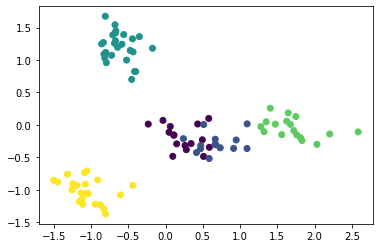

In [ ]:
#Reducing dimensions from 128 to 2 using PCA and plotting the clusters

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pred_pca = pca.fit_transform(pred)
plt.scatter(pred_pca[:,0], pred_pca[:,1], c=y_train)

---
## **5. Face Recognition using KNN**
Distance is calculated of the test 128 length vector from all the 128 length vectors of the x_train set. The image is classified with the label of the closest 7 neighbours.

In [ ]:
def encode_image(model ,img):
    encode = model.predict(img.reshape((1,)+ img.shape))
    return encode

In [ ]:
pred_x_train = anchor_model.predict(x_train)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(pred_x_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

Predicted name: ['mindy_kaling'] with encoding =
 [ 0.17053762  0.11436825  0.0201177   0.06938383  0.10370724  0.10630072
 -0.22313528  0.08147337 -0.20701788  0.19799656  0.18136026  0.08951403
 -0.15457274  0.03056308  0.03516821 -0.2877309  -0.14803053 -0.08591282
  0.2018694   0.10152528 -0.07042465  0.06770816 -0.01596108  0.12403552
 -0.17576046 -0.07487997  0.03810926  0.18697792 -0.02795894  0.00705306
 -0.16955039 -0.11051059  0.12363653 -0.07048211  0.01961709  0.11394292
  0.05608613 -0.16766874 -0.00589908  0.08012756  0.12818633  0.1331438
 -0.18844074  0.00142672 -0.06567442 -0.09643406 -0.08201542  0.19956383
 -0.05203216 -0.03595869 -0.17096025  0.21676989  0.01127196 -0.00063197
 -0.05700162  0.01465672  0.01084469  0.05104692  0.0454996  -0.10226455
  0.12580386 -0.12671463  0.18502592  0.0966426  -0.00956105  0.3569656
 -0.04291133 -0.05879601  0.05183339  0.1468256  -0.10893856  0.15642504
  0.00923867 -0.16524981 -0.22831646  0.19682656  0.11696348  0.02847496
 -0

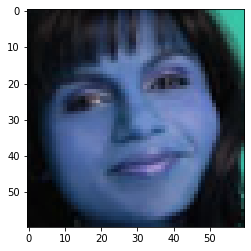

In [ ]:
# Testing model on index 16 of x_test dataset

idx = 16
img = x_test[idx]
plt.imshow(img)

enc = encode_image(anchor_model, img)
pred = neigh.predict(enc)
print("Predicted name:",le.inverse_transform(pred), "with encoding =\n", enc[0])
print("Actual pred: ", le.inverse_transform(y_test[idx:idx+1]))

Predicted name: ['elton_john'] with encoding =
 [-0.25971392 -0.25355268 -0.09596941  0.07788448 -0.01670907 -0.19535558
  0.20877615 -0.15895289  0.17963262 -0.06554352  0.04714579 -0.14690135
 -0.13873152  0.11650472  0.18561016  0.09086282 -0.02106267 -0.20604001
 -0.19135144 -0.10042322  0.06863365  0.07916139 -0.01347714 -0.21515064
  0.09648232  0.05084391 -0.06488772  0.09817745  0.09946975  0.23705281
  0.23484914  0.33433673  0.08047638  0.00492959 -0.15676652  0.01959875
  0.05219126  0.18250166  0.01440204 -0.08696773 -0.0104766  -0.3518804
  0.02329992 -0.1265256   0.02327145 -0.0230996   0.01256549 -0.23630933
  0.0068212  -0.18208739  0.18677585  0.03983531 -0.09495734  0.15449391
 -0.24728248  0.09112729 -0.0757179  -0.11066571  0.2353695   0.17186694
 -0.02519704  0.10089622 -0.09615872  0.24694212 -0.1559117   0.15720421
 -0.00947915  0.12488925 -0.10720826 -0.14074096 -0.04116242 -0.05896768
 -0.14776756 -0.06635483 -0.01254559  0.12019177 -0.11447666 -0.06053139
 -0.

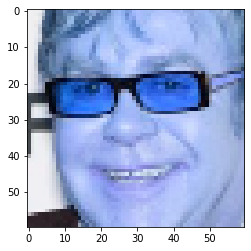

In [ ]:
# Testing model on index 8 of x_test dataset

idx = 8
img = x_test[idx]
plt.imshow(img)

enc = encode_image(anchor_model, img)
pred = neigh.predict(enc)
print("Predicted name:",le.inverse_transform(pred), "with encoding =\n", enc[0])
print("Actual pred: ", le.inverse_transform(y_test[idx:idx+1]))

---
## **6. Model Evaluation using Accuracy**

In [ ]:
pred_x_test = anchor_model.predict(x_test)
pred = neigh.predict(pred_x_test)

print("Accuracy ->",np.sum(pred == y_test)/len(pred))

Accuracy -> 1.0
